##**Installing Dependencies**

In [1]:
#!pip install --no-cache-dir --force-reinstall pandas numpy gensim distance fuzzywuzzy

In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup
import distance
from fuzzywuzzy import fuzz

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('punkt_tab')

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


import gensim.downloader as api

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


##**Downloading The Dataset**

In [3]:
# Download latest version
path = kagglehub.dataset_download("quora/question-pairs-dataset")

print("Path to dataset files:", path)

100%|██████████| 20.8M/20.8M [00:00<00:00, 137MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/quora/question-pairs-dataset/versions/2


In [4]:
df = pd.read_csv(f"{path}/questions.csv")

In [5]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [6]:
df.shape

(404351, 6)

In [7]:
df.value_counts("is_duplicate")

is_duplicate
0    255045
1    149306
Name: count, dtype: int64

In [8]:
df_0 = df[df["is_duplicate"] == 0].head(205000)
df_1 = df[df["is_duplicate"] == 1].head(149306)

In [9]:
dataset = pd.concat([df_0, df_1])

In [10]:
dataset.value_counts("is_duplicate")

is_duplicate
0    205000
1    149306
Name: count, dtype: int64

In [11]:
dataset = dataset.sample(frac=1, random_state=42)

In [12]:
dataset.shape

(354306, 6)

In [13]:
dataset.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64

In [14]:
dataset.dropna(axis = 0, inplace = True)

In [15]:
dataset.head(15)

id    qid1    qid2  \
31965    31965   63713   63714   
31956    31956   63695   63696   
31750    31750   63287   63288   
261236  261236  514063  514064   
275008  275008  540754  540755   
174924  174924  345584  345585   
215589  215589  425110  425111   
96887    96887  192305  192306   
1325      1325    2651    2652   
227897  227897  449122  449123   
253561  253561  499142  499143   
291897  291897  573488  573489   
147936  147936  292696  292697   
385240  385240  753244  753245   
139698  139698  276536  276537   

                                                question1  \
31965        How many businesses in India have a website?   
31956   What has been the best moment in your entire l...   
31750               What is the meaning of ISO in camera?   
261236           Samsung Galaxy grand prime have a volte?   
275008       What is the principle behind chromatography?   
174924  Why does only American people have seen aliens...   
215589                        What can I learn on my own?   
96887   What are some of the objectives of a moral truth?   
1325                 How do I plan a bridal shower party?   
227897               What are the best books for IBPS PO?   
253561     Which is the best book for physical chemistry?   
291897                               How did Quora start?   
147936  Is there any evidence that extraterrestrial be...   
385240       How can I apply for a work permit in the US?   
139698  What is the job of a management trainee in Hin...   

                                                question2  is_duplicate  
31965   How many businesses in India which don't have ...             0  
31956   What is the best moment in your life you can t...             1  
31750                What is the meaning of ISO in DSLRs?             0  
261236          How do I update my HTC phone to Lollipop?             0  
275008   What is chromatography? What are the principles?             1  
174924  When and why did it become common parlance to ...             0  
215589          What would you like to learn on your own?             0  
96887                         What is objective morality?             0  
1325     How can I plan a bridal shower in another state?             1  
227897  What are the best books for preparing IBPS PO ...             1  
253561      What is the best book for physical chemistry?             1  
291897                         How did Quora started out?             1  
147936  Is there any proof or evidence of alien / extr...             1  
385240             How can I get a work permit in the US?             1  
139698  How can I get a job at HAL (Hindustan Aeronaut...             0

In [16]:
dataset = dataset[[ "question1", "question2","is_duplicate"]]

In [17]:
dataset.head(1)

question1  \
31965  How many businesses in India have a website?   

                                               question2  is_duplicate  
31965  How many businesses in India which don't have ...             0

##**Data Preprocessing**

In [18]:
contractions = {
    # Common verb contractions
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "isn't": "is not",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "wasn't": "was not",
    "weren't": "were not",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",

    # Pronoun contractions
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it's": "it is",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she's": "she is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that'll": "that will",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there'll": "there will",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "where'd": "where did",
    "where's": "where is",
    "who'd": "who would",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "why'd": "why did",
    "why's": "why is",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",

    # Special cases and colloquialisms
    "'cause": "because",
    "let's": "let us",
    "ma'am": "madam",
    "o'clock": "of the clock",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "gov't": "government",
    "how'd'y": "how do you"
}

In [19]:
def pre_process(q):
  q = str(q).lower().strip()

  #replace the certail characters with their string replacements
  q = q.replace('%', ' percent')
  q = q.replace('$', ' dollar ')
  q = q.replace('₹', ' rupee ')
  q = q.replace('€', ' euro ')
  q = q.replace('@', ' at ')

  #the pattern [math] appears in the dataset around 900 so we remove it

  q = q.replace("[math]", " ")

  #replacing numbers with strings
  q = q.replace(',000,000,000', 'b')
  q = q.replace(',000,000', 'm')
  q = q.replace(',000', 'k')
  q = re.sub(r'([0-9]+)000000000', r'\1b', q)
  q = re.sub(r'([0-9]+)000000', r'\1m', q)
  q = re.sub(r'([0-9]+)000', r'\1k', q)


  #removing the short form words

  q_decontracted = []

  for word in q.split():
    if word in contractions:
      word = contractions[word]

    q_decontracted.append(word)

  q = ' '.join(q_decontracted)
  q = q.replace("'ve", " have")
  q = q.replace("n't", " not")
  q = q.replace("'re", " are")
  q = q.replace("'ll", " will")

  #removing html tags
  q= BeautifulSoup(q)
  q = q.get_text()

  #remove punctuations
  pattern = re.compile('\W')
  q = re.sub(pattern, ' ', q).strip()


  return q

In [20]:
dataset["question1"] = dataset["question1"].apply(pre_process)
dataset["question2"] = dataset["question2"].apply(pre_process)

In [21]:
dataset.head(2)

question1  \
31965        how many businesses in india have a website   
31956  what has been the best moment in your entire life   

                                               question2  is_duplicate  
31965  how many businesses in india which do not have...             0  
31956  what is the best moment in your life you can t...             1

In [22]:
dataset.isnull().sum()

question1       0
question2       0
is_duplicate    0
dtype: int64

#**Feature Engineering:**
##**Normal Features**:
**1: q1_len** = character length of q1 \
**2: q2_len** = character length of q2 \
**3: q1_words** = number of words in q1 \
**4: q2_words** = number of words in q2 \
**5: words_common** = number of common unique words \
**6: words_total** = total number of words in q1 + q2 \
**7: words_share** = words common/words total

##**Token Features:**
**8: cwc_min** = This is the ratio of num of common wordsto the length of smaller qs\
**9: cwc_max** = This is the ratio of num of common wordsto the length of larger qs\
**10: csc_min** = This is the ratio of num of common stop words to the smaller stop words count amoung the two qs\
**11: csc_max** =This is the ratio of num of common stop words to the larger stop words count amoung the two qs\
**12: ctc_min** = This is the ratio of number of common tokens to the smaller token conts amoung the two questions\
**13: ctc_max** = This is the ratio of number of common tokens to the larger token counts amoung the two questions\
**14: last_word_eq** = If the last word in the two qs is same\
**15: first_word_eq** = If the first word in the two qs in same

##**Length Based Features:**
**16: mean_len** =  mean of the length of two qs(number of words)\
**17: abs_len_diff**= Absolute difference between the length of two qs\
**18: longest_substr_ratio** = Ratio of the length of largest substring amoung the two qsto the length of smaller qs

##**Fuzzy Features:**
**19: fuzz_ratio** = fuzz_ratio from fuzzywuzzy \
**20: fuzz_partial_ratio** = fuzz_partial_ratio from fuzzywuzzy \
**21: token_sort_ratio** = token_sort_ratio from fuzzywuzzy \
**22: token_set_ratio** = token_set_ratio from fuzzywuzzy

##**Normal Features**

In [23]:
def fetch_normal_features(row):

  q1 = row["question1"]
  q2 = row["question2"]

  normal_features = [0.0]*7

  normal_features[0] = len(q1)
  normal_features[1] = len(q2)

  normal_features[2] = len(q1.split(" "))
  normal_features[3] = len(q2.split(" "))

  common_words = set(word for word in q1.split(" ") if word in q2.split(" "))
  normal_features[4] = len(common_words)

  normal_features[5] = len(set(q1.split(" "))) + len(set(q2.split(" ")))

  normal_features[6] = round(len(common_words)/normal_features[5],2)

  return normal_features


In [24]:
normal_features = dataset.apply(fetch_normal_features, axis =1)

dataset["q1_len"] = list(map(lambda x : x[0], normal_features))
dataset["q2_len"] = list(map(lambda x : x[1], normal_features))
dataset["q1_words"] = list(map(lambda x : x[2], normal_features))
dataset["q2_words"] = list(map(lambda x : x[3], normal_features))
dataset["words_common"] = list(map(lambda x : x[4], normal_features))
dataset["words_total"] = list(map(lambda x : x[5], normal_features))
dataset["words_share"] = list(map(lambda x : x[6], normal_features))

In [25]:
dataset.head(2)

question1  \
31965        how many businesses in india have a website   
31956  what has been the best moment in your entire life   

                                               question2  is_duplicate  \
31965  how many businesses in india which do not have...             0   
31956  what is the best moment in your life you can t...             1   

       q1_len  q2_len  q1_words  q2_words  words_common  words_total  \
31965      43      56         8        11             8           19   
31956      49      53        10        12             7           22   

       words_share  
31965         0.42  
31956         0.32

##**Token Features**

In [26]:
def fetch_token_features(row):

  q1 = row["question1"]
  q2 = row["question2"]

  beta = 0.001

  STOP_WORDS = stopwords.words("english")

  token_features = [0.0]*8

  #converting sentences into tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
    return token_features

  #get the non stop words
  q1_words = set([words for words in q1_tokens if words not in STOP_WORDS])
  q2_words = set([words for words in q2_tokens if words not in STOP_WORDS])

  #GET THE STOP WORDS
  q1_stopwords = set([words for words in q1_tokens if words in STOP_WORDS])
  q2_stopwords = set([words for words in q2_tokens if words in STOP_WORDS])

  #GET THE COMMON NON STOPWORDS
  common_words_count = len(q1_words.intersection(q2_words))

  #get the common stopwords
  common_stopwords_count = len(q1_stopwords.intersection(q2_stopwords))

  #get the common tokens
  common_token_count = len(set(q1_tokens).intersection((q2_tokens)))

  token_features[0] = common_words_count/ (min(len(q1_words), len(q2_words)) + beta)
  token_features[1] = common_words_count/ (max(len(q1_words), len(q2_words)) + beta)
  token_features[2] = common_stopwords_count/ (max(len(q1_stopwords), len(q2_stopwords)) + beta)
  token_features[3] = common_stopwords_count/ (max(len(q1_stopwords), len(q2_stopwords)) + beta)
  token_features[4] = common_token_count/ (max(len(q1_tokens), len(q2_tokens)) + beta)
  token_features[5] = common_token_count/ (max(len(q1_tokens), len(q2_tokens)) + beta)

  #last words of the batch
  token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

  #first word of the batch
  token_features[7] = int(q1_tokens[0] == q2_tokens[0])

  return token_features



In [27]:
token_features = dataset.apply(fetch_token_features, axis =1)

dataset["cwc_min"] = list(map(lambda x : x[0], token_features))
dataset["cwc_max"] = list(map(lambda x : x[1], token_features))
dataset["csc_min"] = list(map(lambda x : x[2], token_features))
dataset["csc_max"] = list(map(lambda x : x[3], token_features))
dataset["ctc_min"] = list(map(lambda x : x[4], token_features))
dataset["ctc_max"] = list(map(lambda x : x[5], token_features))
dataset["last_word_eq"] = list(map(lambda x : x[6], token_features))
dataset["first_word_eq"] = list(map(lambda x : x[7], token_features))

In [28]:
dataset.head(2)

question1  \
31965        how many businesses in india have a website   
31956  what has been the best moment in your entire life   

                                               question2  is_duplicate  \
31965  how many businesses in india which do not have...             0   
31956  what is the best moment in your life you can t...             1   

       q1_len  q2_len  q1_words  q2_words  words_common  words_total  \
31965      43      56         8        11             8           19   
31956      49      53        10        12             7           22   

       words_share   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
31965         0.42  0.999750  0.999750  0.571347  0.571347  0.727207   
31956         0.32  0.749813  0.749813  0.499938  0.499938  0.583285   

        ctc_max  last_word_eq  first_word_eq  
31965  0.727207           1.0            1.0  
31956  0.583285           0.0            1.0

##**Length Based Features**

In [29]:
def fetch_length_features(row):

  q1 = row["question1"]
  q2 = row["question2"]

  length_features = [0.0]*3

  #converting sentences into tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if len(q1_tokens) == 0 or len(q2_tokens) == 0:
    return length_features

  #absolute len feature
  length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

  #average token length
  length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

  #longest substring ratio
  strs = list(distance.lcsubstrings(q1, q2))
  # Check if strs is not empty before accessing the first element
  if len(strs) > 0:
      length_features[2] = len(strs[0])/ (min(len(q1), len(q2)) + 1)
  else:
      # If no common substring is found, the ratio is 0
      length_features[2] = 0.0

  return length_features


In [30]:
length_features = dataset.apply(fetch_length_features, axis =1)

dataset["abs_len_diff"] = list(map(lambda x : x[0], length_features))
dataset["mean_len"] = list(map(lambda x : x[1], length_features))
dataset["longest_substring_ratio"] = list(map(lambda x : x[2], length_features))

In [31]:
dataset.head(1)

question1  \
31965  how many businesses in india have a website   

                                               question2  is_duplicate  \
31965  how many businesses in india which do not have...             0   

       q1_len  q2_len  q1_words  q2_words  words_common  words_total  \
31965      43      56         8        11             8           19   

       words_share  ...  cwc_max   csc_min   csc_max   ctc_min   ctc_max  \
31965         0.42  ...  0.99975  0.571347  0.571347  0.727207  0.727207   

       last_word_eq  first_word_eq  abs_len_diff  mean_len  \
31965           1.0            1.0           3.0       9.5   

       longest_substring_ratio  
31965                 0.659091  

[1 rows x 21 columns]

##**Fuzzy Features**

In [32]:
def fetch_fuzzy_features(row):

  q1 = row["question1"]
  q2 = row["question2"]

  fuzzy_features = [0.0]*4

  #fuzz ratio
  fuzzy_features[0] = fuzz.QRatio(q1, q2)

  #fuzz partial ratio
  fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

  #token sort ratio
  fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

  #token set ratio
  fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

  return fuzzy_features


In [33]:
fuzzy_features = dataset.apply(fetch_fuzzy_features, axis =1)

dataset["fuzz_ratio"] = list(map(lambda x : x[0], fuzzy_features))
dataset["fuzz_partial_ratio"] = list(map(lambda x : x[1], fuzzy_features))
dataset["fuzz_sort_ratio"] = list(map(lambda x : x[2], fuzzy_features))
dataset["fuzz_set_ratio"] = list(map(lambda x : x[3], fuzzy_features))

In [34]:
dataset.head(2)

question1  \
31965        how many businesses in india have a website   
31956  what has been the best moment in your entire life   

                                               question2  is_duplicate  \
31965  how many businesses in india which do not have...             0   
31956  what is the best moment in your life you can t...             1   

       q1_len  q2_len  q1_words  q2_words  words_common  words_total  \
31965      43      56         8        11             8           19   
31956      49      53        10        12             7           22   

       words_share  ...   ctc_max  last_word_eq  first_word_eq  abs_len_diff  \
31965         0.42  ...  0.727207           1.0            1.0           3.0   
31956         0.32  ...  0.583285           0.0            1.0           2.0   

       mean_len  longest_substring_ratio  fuzz_ratio  fuzz_partial_ratio  \
31965       9.5                 0.659091          87                  77   
31956      11.0                 0.500000          69                  71   

       fuzz_sort_ratio  fuzz_set_ratio  
31965               87             100  
31956               69              80  

[2 rows x 25 columns]

##**Exploratory Data Analysis**

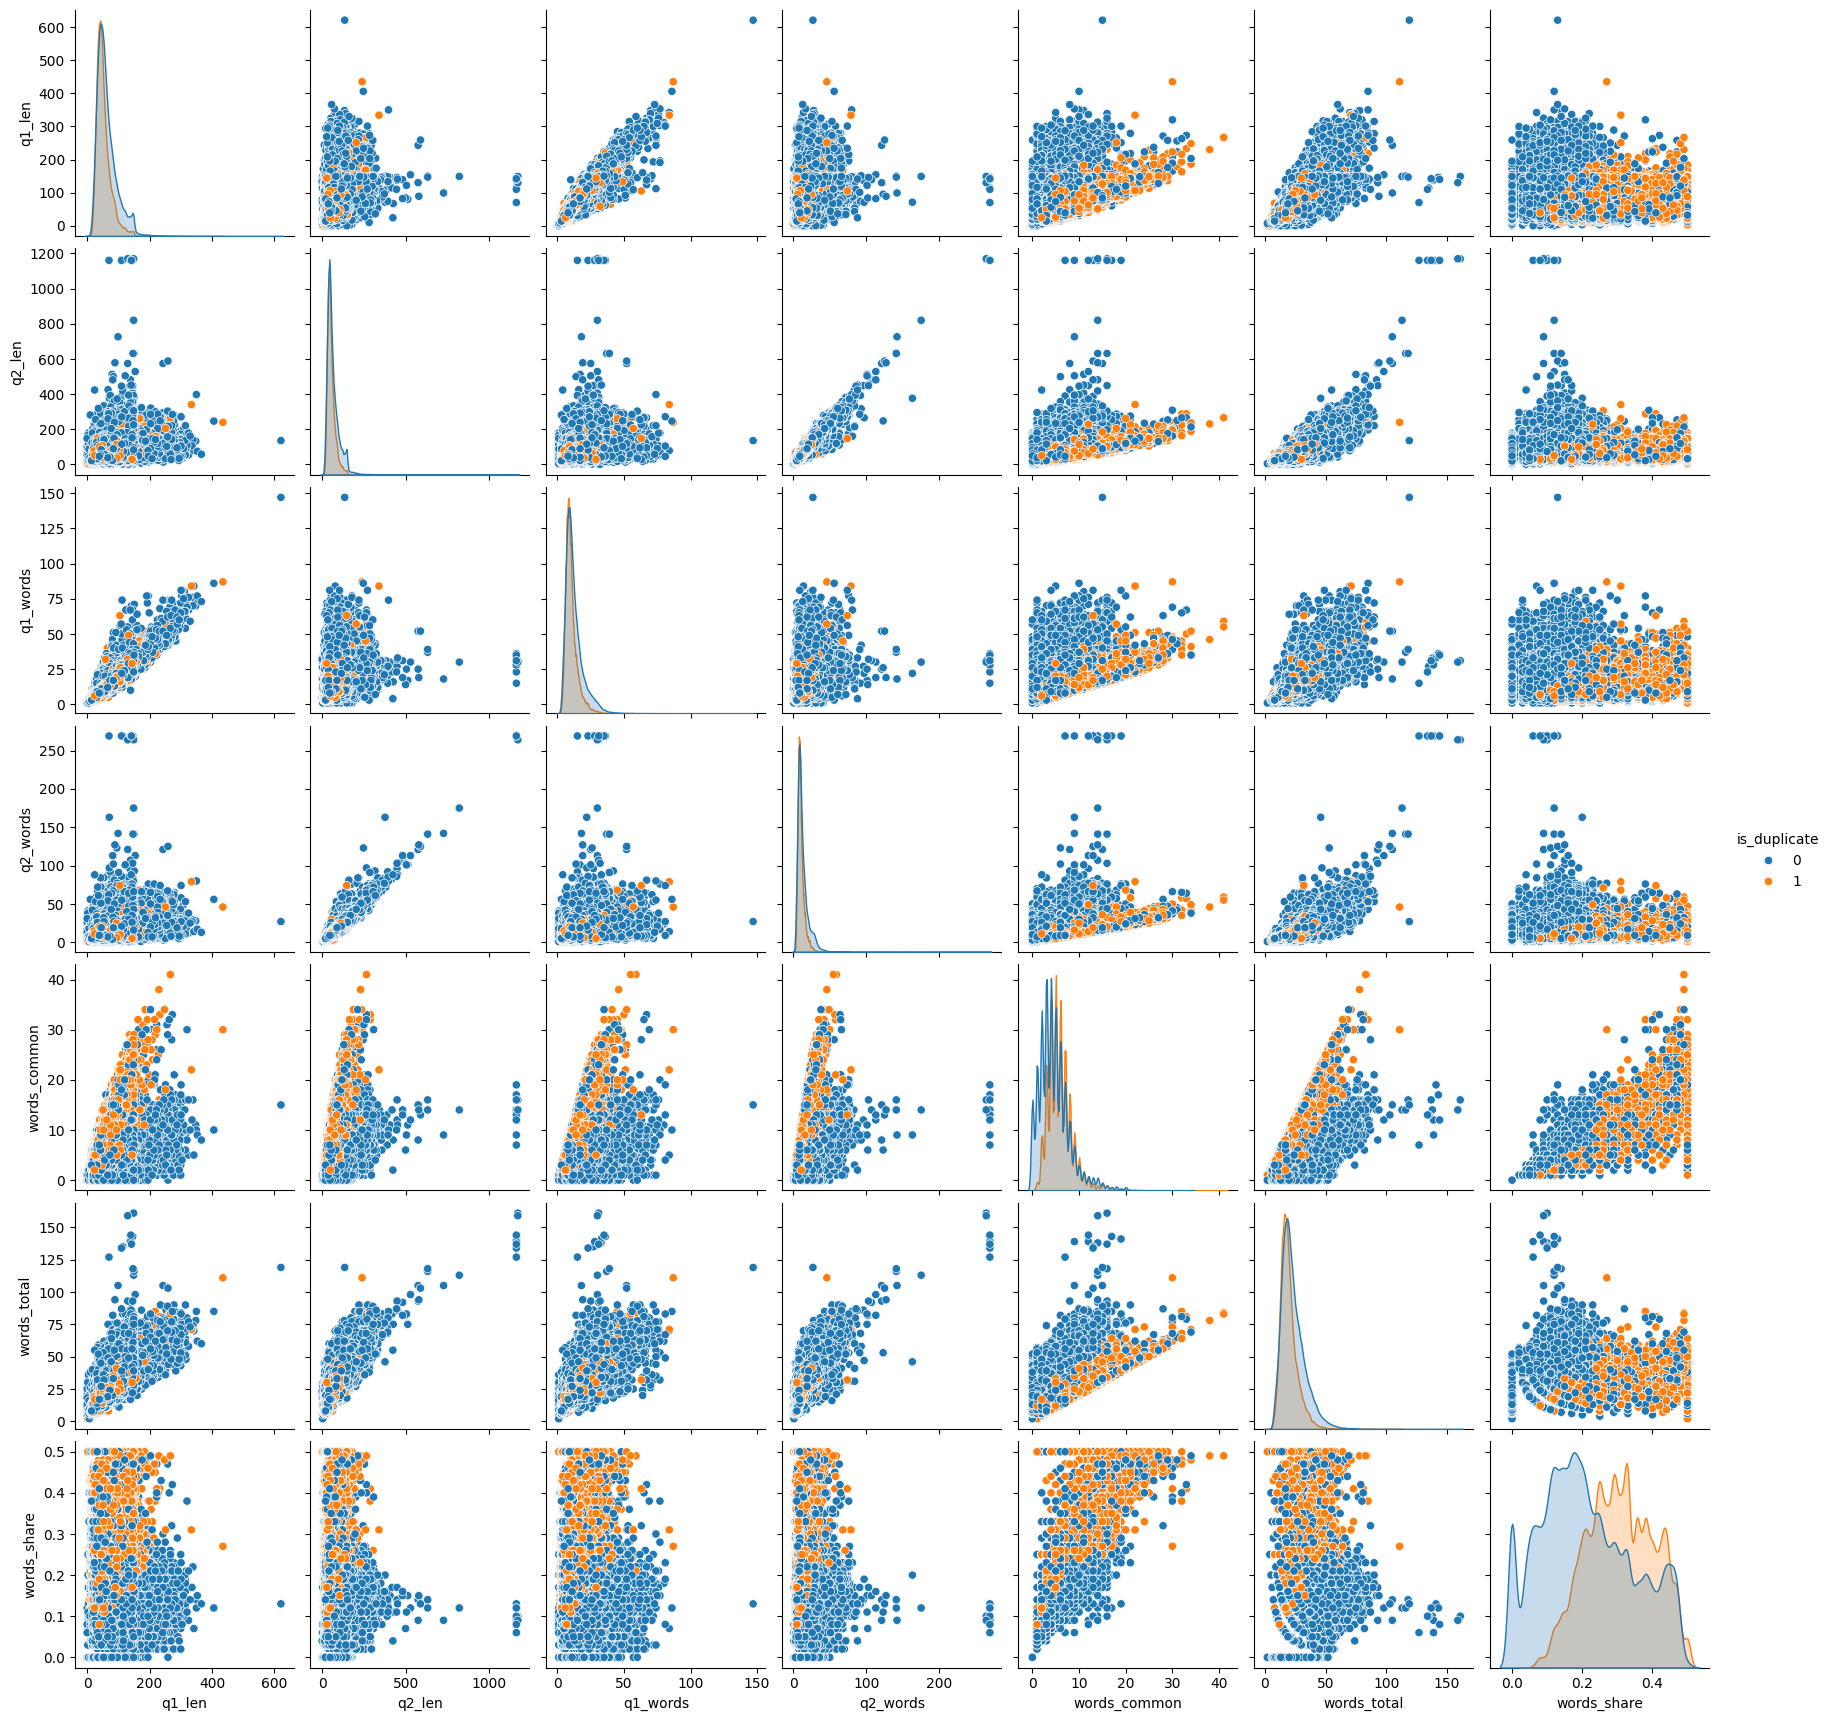

In [35]:
sns.pairplot(dataset[["q1_len", "q2_len", "q1_words", "q2_words", "words_common", "words_total", "words_share", "is_duplicate"]], hue="is_duplicate")

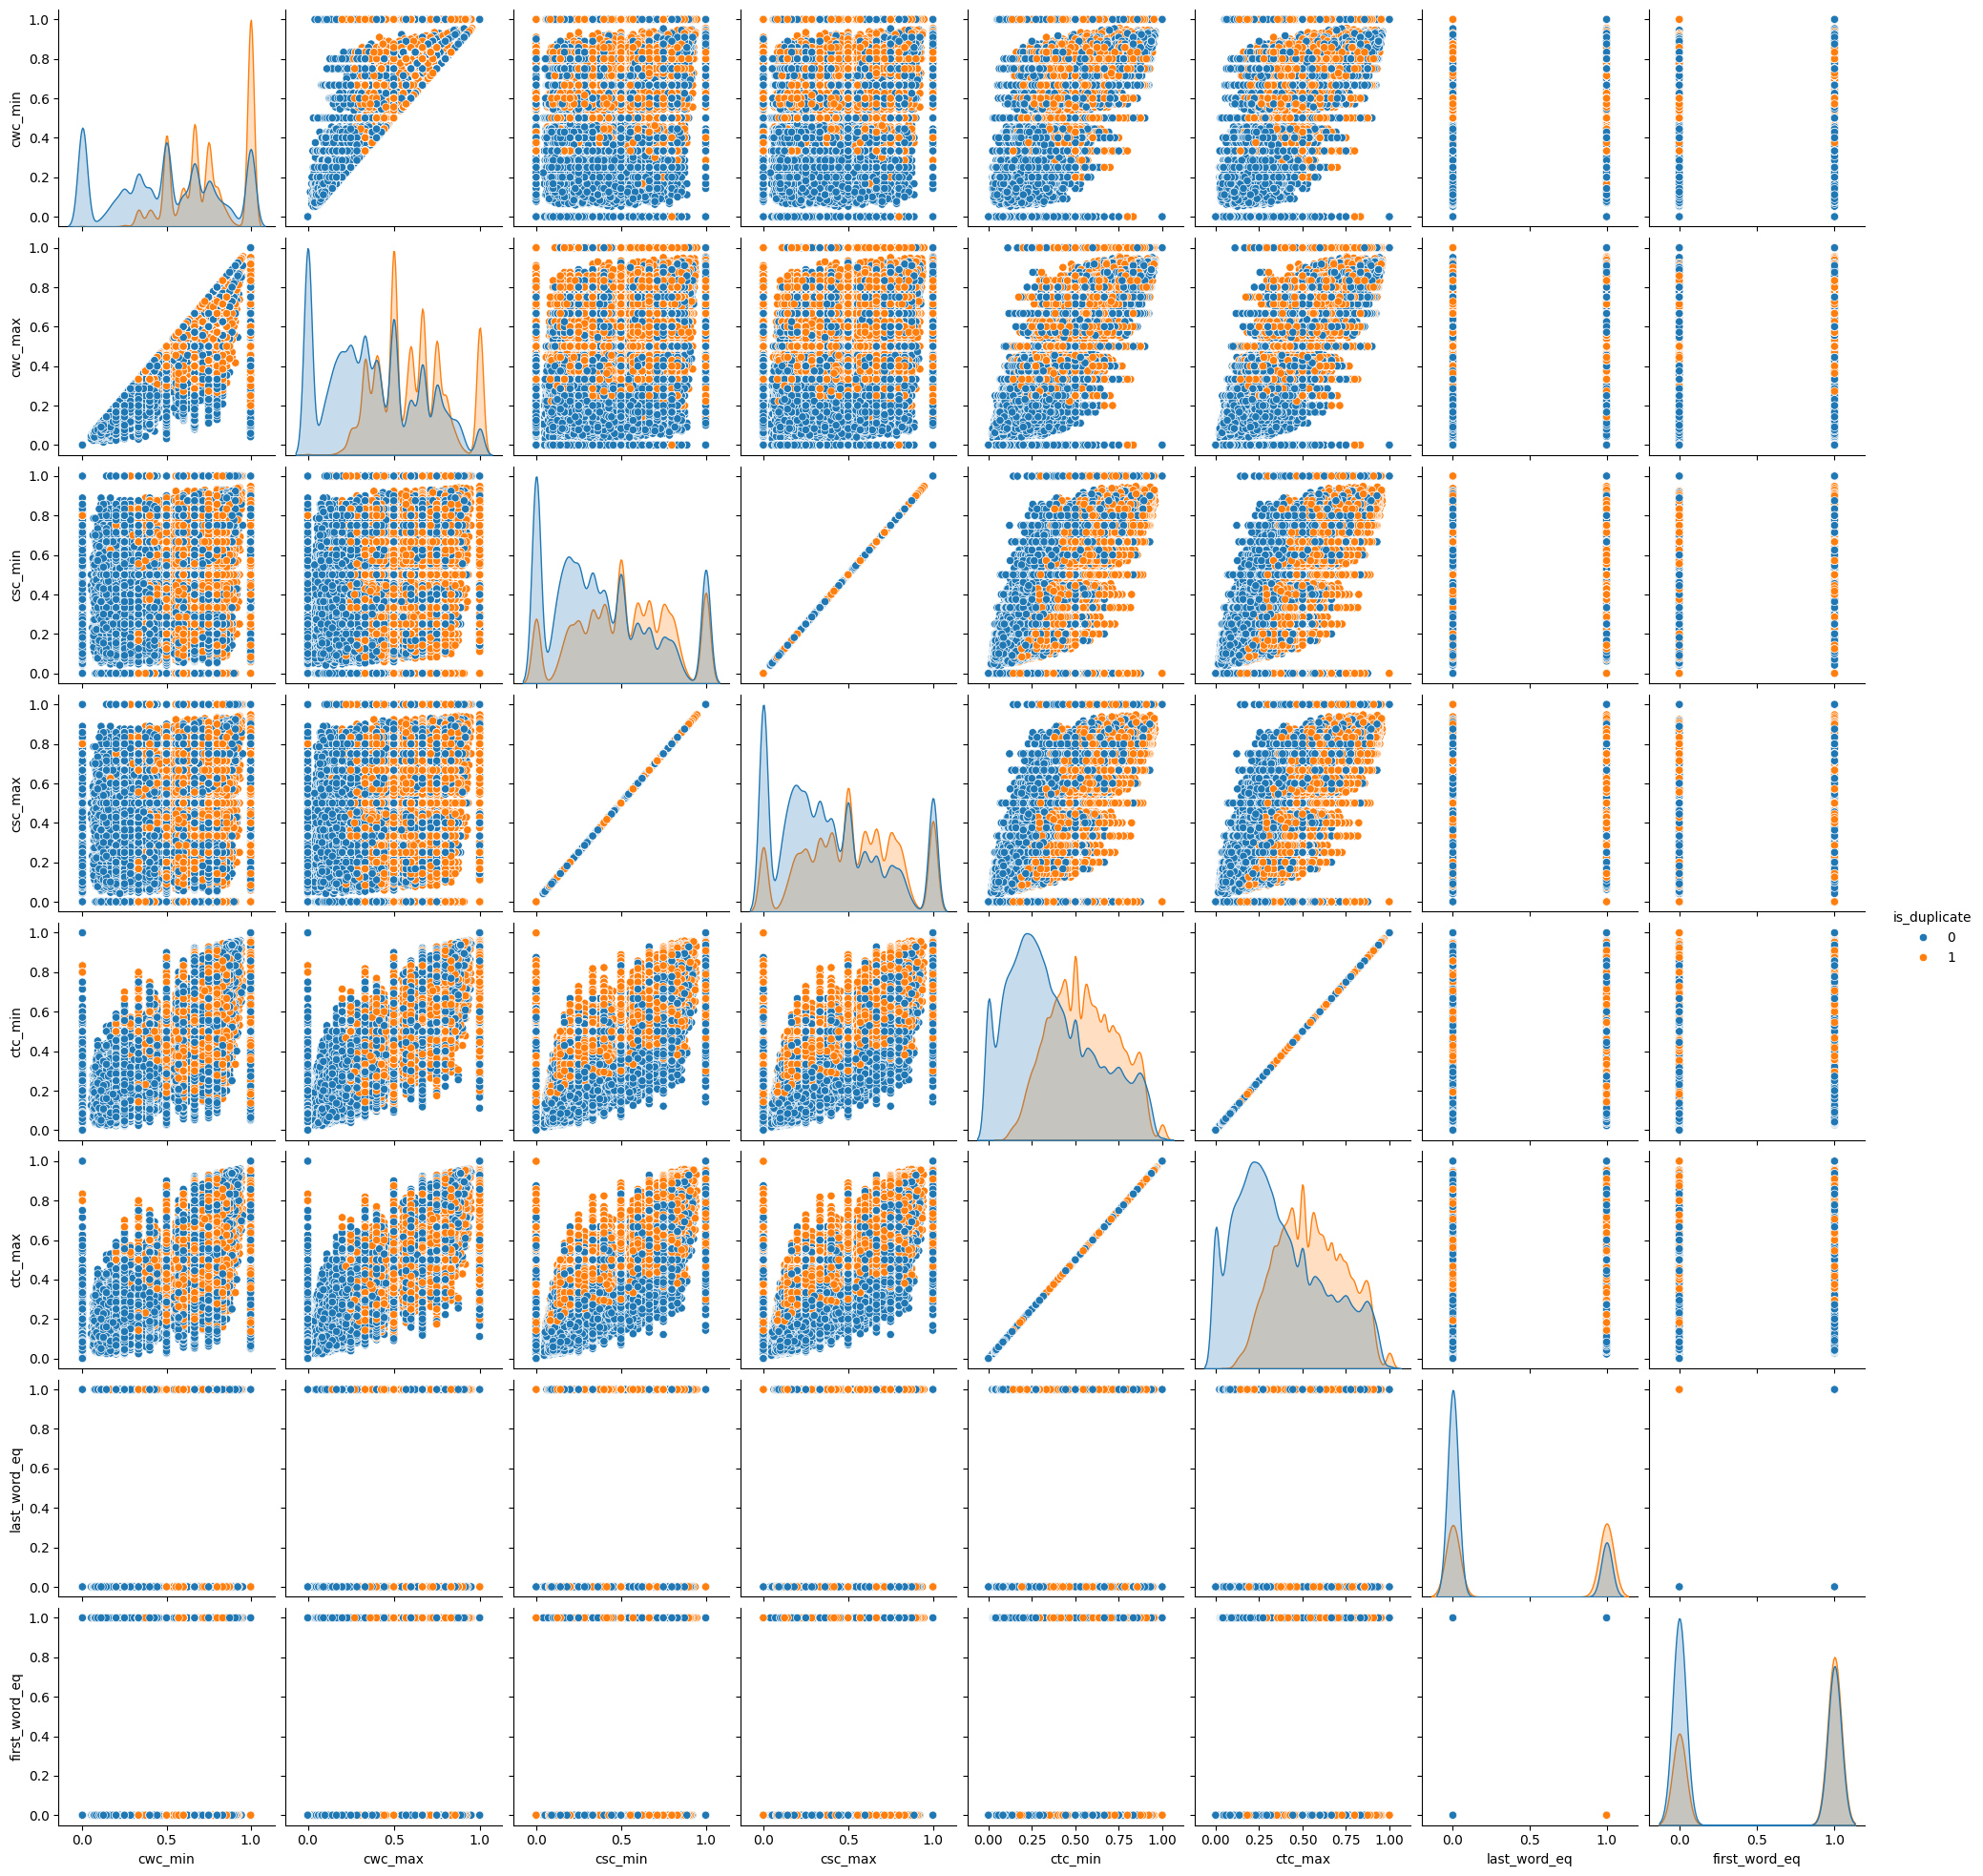

In [36]:
sns.pairplot(dataset[["cwc_min", "cwc_max", "csc_min", "csc_max", "ctc_min", "ctc_max", "last_word_eq", "first_word_eq", "is_duplicate"]], hue = "is_duplicate")

In [ ]:
sns.pairplot(dataset[["abs_len_diff", "mean_len", "longest_substring_ratio", "is_duplicate"]], hue = "is_duplicate")

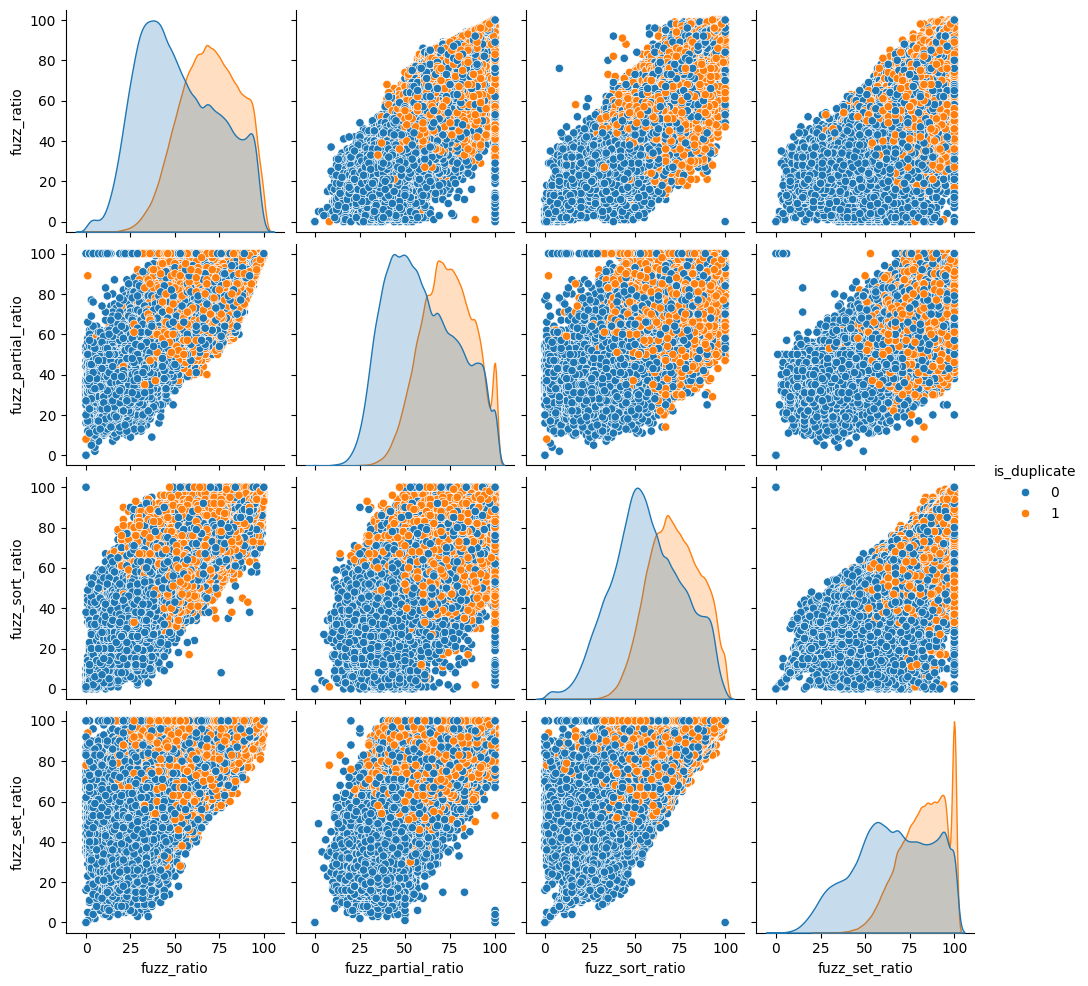

In [38]:
sns.pairplot(dataset[["fuzz_ratio", "fuzz_partial_ratio", "fuzz_sort_ratio", "fuzz_set_ratio", "is_duplicate"]], hue = "is_duplicate")

##**Creating Word Embeddings**



In [ ]:
# Load the pre-trained model
print("Loading Word2Vec model...")
word_vectors = api.load("word2vec-google-news-300")
vector_size = word_vectors.vector_size
print("Model loaded successfully!")


Loading Word2Vec model...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model loaded successfully!


In [ ]:
def preprocess(text):
    return word_tokenize(text.lower())

def get_sentence_vector(sentence, model):
    words = preprocess(sentence)
    vectors = []
    for word in words:
        if word in model.key_to_index:
            vectors.append(model[word])
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [ ]:
# Create embeddings for both questions
dataset['q1_embedding'] = dataset['question1'].apply(lambda x: get_sentence_vector(x, word_vectors))
dataset['q2_embedding'] = dataset['question2'].apply(lambda x: get_sentence_vector(x, word_vectors))


In [ ]:
dataset.head(2)

question1  \
265774  what are the steps to becoming the perfect acc...   
136262  how can i admit to my wife that she cannot use...   

                                                question2  is_duplicate  \
265774                  how can i be a perfect accountant             1   
136262  after i delete a low quality page from my webs...             0   

        q1_len  q2_len  q1_words  q2_words  words_common  words_total  \
265774      53      33         9         7             2           15   
136262      98      80        20        17             2           35   

        words_share  ...  first_word_eq  abs_len_diff  mean_len  \
265774         0.13  ...            0.0           2.0       8.0   
136262         0.06  ...            0.0           4.0      18.0   

        longest_substring_ratio  fuzz_ratio  fuzz_partial_ratio  \
265774                 0.558824          60                  73   
136262                 0.061728          22                  36   

        fuzz_sort_ratio  fuzz_set_ratio  \
265774               56              71   
136262               35              41   

                                             q1_embedding  \
265774  [0.021087646, 0.066856384, -0.03609085, 0.0169...   
136262  [0.056871034, -0.040703677, 0.053363036, 0.116...   

                                             q2_embedding  
265774  [0.045043945, -0.059733074, 0.017578125, 0.082...  
136262  [0.009806707, 0.017011862, 0.09050575, 0.08974...  

[2 rows x 27 columns]

In [ ]:
# Visualize embeddings using t-SNE
def plot_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embeddings_2d[:, 0],
        y=embeddings_2d[:, 1],
        hue=labels,
        palette="viridis",
        alpha=0.7
    )
    plt.title(title)
    plt.show()


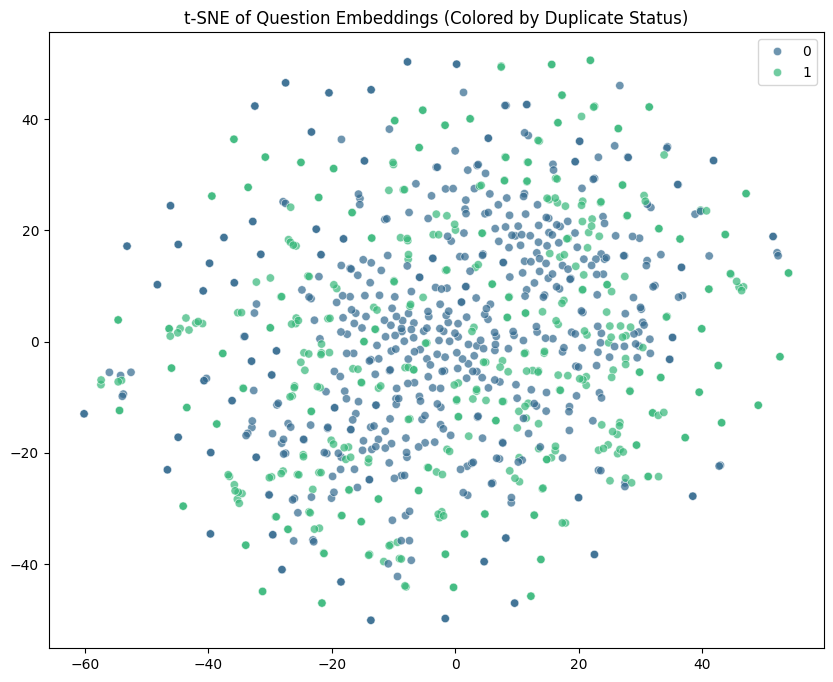

In [ ]:
# Combine some embeddings for visualization
sample_size = 500
sample_data = dataset.sample(sample_size, random_state=42)
combined_embeddings = np.vstack(sample_data['q1_embedding'].to_numpy())
combined_embeddings = np.vstack([combined_embeddings, np.vstack(sample_data['q2_embedding'].to_numpy())])

combined_labels = np.concatenate([sample_data['is_duplicate'].values, sample_data['is_duplicate'].values])

plot_embeddings(combined_embeddings, combined_labels, "t-SNE of Question Embeddings (Colored by Duplicate Status)")

##**Data Preperation for Training**

In [ ]:
# Extract all non-text features (excluding question texts and embeddings)
other_features = [
    "q1_len", "q2_len", "q1_words", "q2_words", "words_common", "words_total",
    "words_share", "cwc_min", "cwc_max", "csc_min", "csc_max", "ctc_min",
    "ctc_max", "last_word_eq", "first_word_eq", "abs_len_diff", "mean_len",
    "longest_substring_ratio", "fuzz_ratio", "fuzz_partial_ratio",
    "fuzz_sort_ratio", "fuzz_set_ratio"
]


In [ ]:
# Convert embeddings to numpy arrays
q1_embs = np.stack(dataset['q1_embedding'].values)
q2_embs = np.stack(dataset['q2_embedding'].values)


In [ ]:
# Other features matrix
other_feats = dataset[other_features].values


In [ ]:
# Normalize other features

scaler = StandardScaler()
other_feats = scaler.fit_transform(other_feats)


In [ ]:
# Labels
labels = dataset['is_duplicate'].values


In [ ]:
# Split data
(X_q1_train, X_q1_val,
 X_q2_train, X_q2_val,
 X_other_train, X_other_val,
 y_train, y_val) = train_test_split(
    q1_embs, q2_embs, other_feats, labels,
    test_size=0.2, random_state=42,
    stratify=labels  # Important for imbalanced datasets
)


In [ ]:
(X_q1_val, X_q1_test,
 X_q2_val, X_q2_test,
 X_other_val, X_other_test,
 y_val, y_test) = train_test_split(
    X_q1_val, X_q2_val, X_other_val, y_val,
    test_size=0.5, random_state=42,
    stratify=y_val
)

##**Model Creation, Compiling, and Training**

In [ ]:
# Input layers
q1_input = Input(shape=(vector_size,), name='q1_embedding')
q2_input = Input(shape=(vector_size,), name='q2_embedding')
other_features_input = Input(shape=(len(other_features),), name='other_features')


In [ ]:
# Enhanced architecture for question embeddings
q1_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(q1_input)
q1_layer = BatchNormalization()(q1_layer)
q1_layer = Dropout(0.3)(q1_layer)
q1_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(q1_layer)

q2_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(q2_input)
q2_layer = BatchNormalization()(q2_layer)
q2_layer = Dropout(0.3)(q2_layer)
q2_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(q2_layer)

# Process other features with more capacity
other_features_layer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(other_features_input)
other_features_layer = BatchNormalization()(other_features_layer)
other_features_layer = Dropout(0.3)(other_features_layer)
other_features_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(other_features_layer)

# Concatenate all features
merged = Concatenate()([q1_layer, q2_layer, other_features_layer])

# Additional layers with skip connections
x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)


In [ ]:
# Create model
model = Model(
    inputs=[q1_input, q2_input, other_features_input],
    outputs=output
)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ q1_embedding        │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q2_embedding        │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     38,528 │ q1_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     38,528 │ q2_embedding[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │      5,888 │ other_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     16,448 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ dense_10[0][0],   │
│ (Concatenate)       │                   │            │ dense_12[0][0],   │
│                     │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │     49,408 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │     16,448 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 185,153 (723.25 KB)

 Trainable params: 183,489 (716.75 KB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Class weights for imbalanced data

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


In [ ]:
# Train model
early_stopping = EarlyStopping(
    monitor='val_precision',
    patience=10,
    restore_best_weights=True,
    mode='max',
    min_delta=0.001
)

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 10:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1).numpy()
    learning_rate = tf.math.maximum(learning_rate, 0.0001).numpy()
  return learning_rate

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
history = model.fit(
    [X_q1_train, X_q2_train, X_other_train],
    y_train,
    validation_data=([X_q1_val, X_q2_val, X_other_val], y_val),
    epochs=200,
    batch_size=1500,
    callbacks=[early_stopping, scheduler_callback],
    class_weight=class_weights
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.6889 - loss: 4.5094 - precision_1: 0.6053 - recall_1: 0.7808 - val_accuracy: 0.5573 - val_loss: 0.9199 - val_precision_1: 0.4912 - val_recall_1: 1.0000 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.7707 - loss: 0.6014 - precision_1: 0.6857 - recall_1: 0.8528 - val_accuracy: 0.7265 - val_loss: 0.6370 - val_precision_1: 0.6193 - val_recall_1: 0.9350 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7784 - loss: 0.4792 - precision_1: 0.6944 - recall_1: 0.8601 - val_accuracy: 0.7647 - val_loss: 0.5203 - val_precision_1: 0.6656 - val_recall_1: 0.9031 - learning_rate: 0.0010

Epoch 4: LearningRateSch

##**Model Testing**

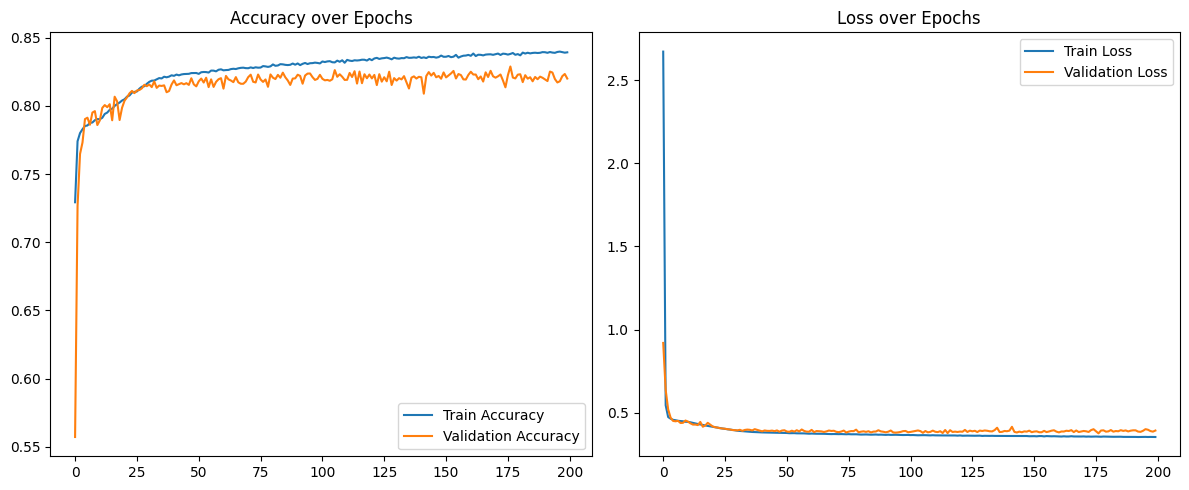

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [ ]:
# Evaluate on test set
results = model.evaluate([X_q1_test, X_q2_test, X_other_test], y_test)
print(f"Test Accuracy: {results[1]:.2%}")
print(f"Test Precision: {results[2]:.2%}")
print(f"Test Recall: {results[3]:.2%}")


1092/1092 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8233 - loss: 0.3881 - precision_1: 0.7423 - recall_1: 0.9072
Test Accuracy: 81.98%
Test Precision: 73.51%
Test Recall: 90.44%


In [ ]:
# Make predictions
y_pred = model.predict([X_q1_test, X_q2_test, X_other_test])
y_pred_class = (y_pred > 0.5).astype(int)


1092/1092 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
# Classification report and confusion matrix

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     20000
           1       0.74      0.90      0.81     14931

    accuracy                           0.82     34931
   macro avg       0.82      0.83      0.82     34931
weighted avg       0.84      0.82      0.82     34931



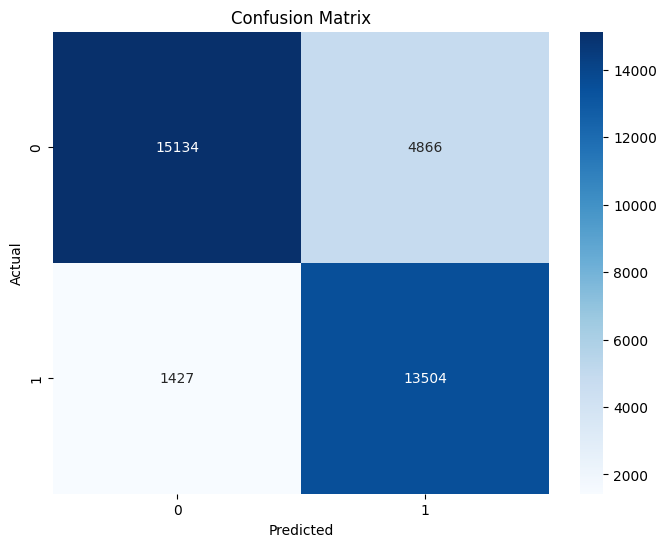

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_class), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##**Downloading the Model**

In [ ]:
from google.colab import files
import dill
import gensim
from tensorflow.keras.models import save_model


In [ ]:
# Save the feature scaler
with open('feature_scaler.pkl', 'wb') as f:
    dill.dump(scaler, f)

# Save Word2Vec model (just the vectors, not the full model)
word_vectors.save('word2vec_vectors.kv*')

# Save the Keras model
model.save('duplicate_questions_model.h5')

In [ ]:

files_to_download = [
    'word2vec_vectors.kv',
    'feature_scaler.pkl',
    'duplicate_questions_model.h5',
]

for file in files_to_download:
  if file == 'word2vec_vectors.kv':
    for f in file:
      files.download(f)
  else:
    files.download(file)